In [1]:
import os

base_directory = os.getcwd()# store your base directory for easy reference
print(base_directory)

#assignment_two_data = os.pardir + '\\Assignments\\Homework_Two_Data\\'
assignment_two_data = os.pardir + '/Assignments/Homework_Two_Data'

/home/ccurtis/Desktop/MATH_596_Git_Clone/Lecture_Notes


In [2]:
# Load core libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from sklearn.cluster import KMeans

from math_596_image_analysis_helper_functions import *
# Jupyter notebook "magic"
%matplotlib inline

## Building Face Space

In [3]:
# Build image lists for cropped and uncropped images
cropped_directory = assignment_two_data + '/CroppedYale/'
cropped_image_list = file_builder(cropped_directory)

In [4]:
num_crp_images = len(cropped_image_list)
crp_row, crp_col = np.shape(cropped_image_list[0])
crp_image_mat = np.zeros((crp_row*crp_col, num_crp_images), dtype=np.float64)
for cnt, image in enumerate(cropped_image_list):
    crp_image_mat[:, cnt] = image.flatten()

print(f"Total number of images is: {num_crp_images}")
print(f"Pixel counts are {crp_row} by {crp_col}")


Total number of images is: 512
Pixel counts are 192 by 168


## Naive Training Sets

In [5]:
percentage_training = .75
mode_selection_threshhold = 2.

num_train_images = int(np.floor(percentage_training * num_crp_images))
train_indices = np.random.choice(np.arange(num_crp_images), num_train_images, replace=False)
training_images = crp_image_mat[:, train_indices]

test_images = np.delete(crp_image_mat, train_indices, axis=1)
zero_avg_test, avg_test = zero_mean(test_images)

zero_avg_train, avg_train = zero_mean(training_images)
u_train, s_train = mode_builder(zero_avg_train)
u_red = mode_selector(u_train, s_train, mode_selection_threshhold)

print(f"Number of Training Images is: {num_train_images}")
print(f"Number of Selected Modes is: {u_red.shape[1]}")

Number of Training Images is: 384
Number of Selected Modes is: 205


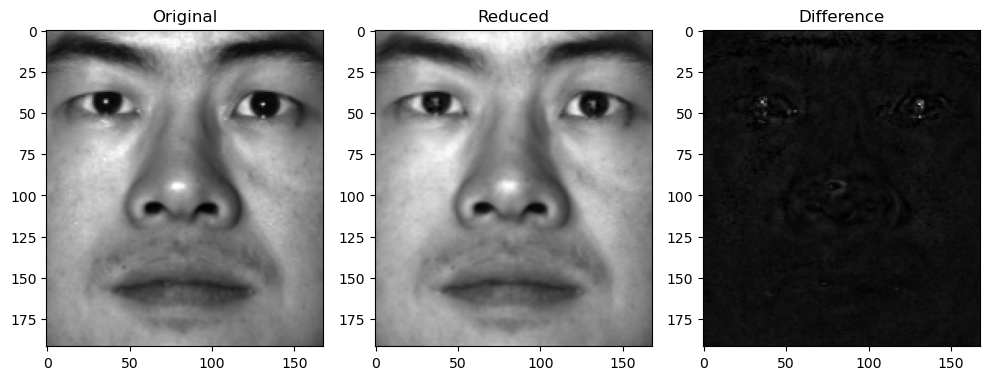

In [6]:
test_choice_ind = 0
test_image_approx = mode_projector(zero_avg_test, u_red)
test_image_approx += avg_test

test_true_mat = test_images[:, test_choice_ind].reshape(crp_row, crp_col)
test_approx_mat = test_image_approx[:, test_choice_ind].reshape(crp_row, crp_col)

image_comparison(test_true_mat, test_approx_mat)

## Less Naive Decompositions Because We Took Some Time to Learn Our Data

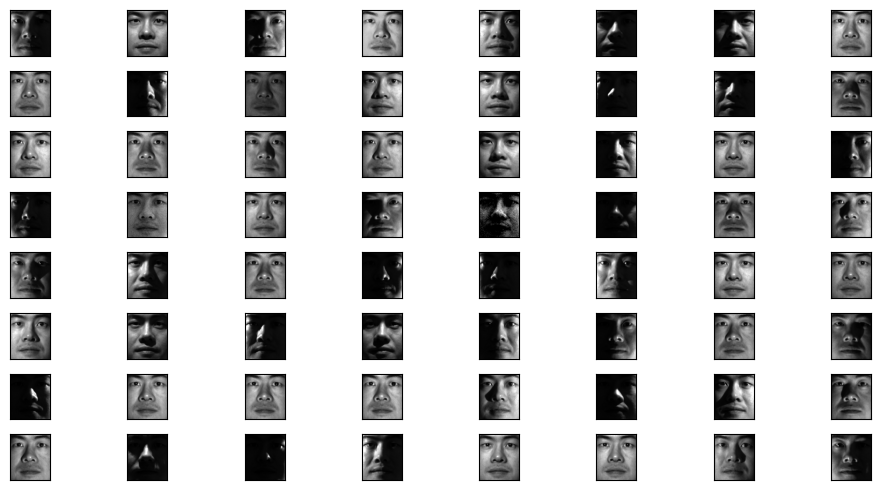

In [7]:
num_angles = 64
fig, axes = plt.subplots(8, 8, figsize=(10, 5))
ax = axes.ravel()
for jj in range(num_angles):
    ax[jj].imshow(crp_image_mat[:, jj].reshape(crp_row, crp_col), cmap=plt.cm.gray)
    ax[jj].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off    
    left=False,        # ticks along the left edge are off
    labelbottom=False,
    labelleft=False
    ) 
fig.tight_layout()

In [8]:
percentage_training = .8
mode_selection_threshhold = 1.

num_distinct_people = int(num_crp_images/num_angles)
num_train_people = int(np.floor(percentage_training * num_distinct_people))
train_people = np.random.choice(np.arange(num_distinct_people), num_train_people, replace=False)

train_indices = np.zeros(num_train_people*num_angles, dtype=int)
for ll in range(num_train_people):
    train_indices[ll*num_angles:num_angles*(ll+1)] = np.arange(train_people[ll]*num_angles,(train_people[ll]+1)*num_angles)
training_images = crp_image_mat[:, np.sort(train_indices)]

testing_images = np.delete(crp_image_mat, train_indices, axis=1)
zero_avg_test, avg_test = zero_mean(test_images)

zero_avg_train, avg_train = zero_mean(training_images)
u_train, s_train = mode_builder(zero_avg_train)
u_red = mode_selector(u_train, s_train, mode_selection_threshhold)

print(f"Number of Distinct People is: {num_distinct_people}")
print(f"Number of Distinct Training People is: {num_train_people}")
print(f"Number of Training Images is: {training_images.shape[1]}")
print(f"Number of Selected Modes is: {u_red.shape[1]}")

Number of Distinct People is: 8
Number of Distinct Training People is: 6
Number of Training Images is: 384
Number of Selected Modes is: 15


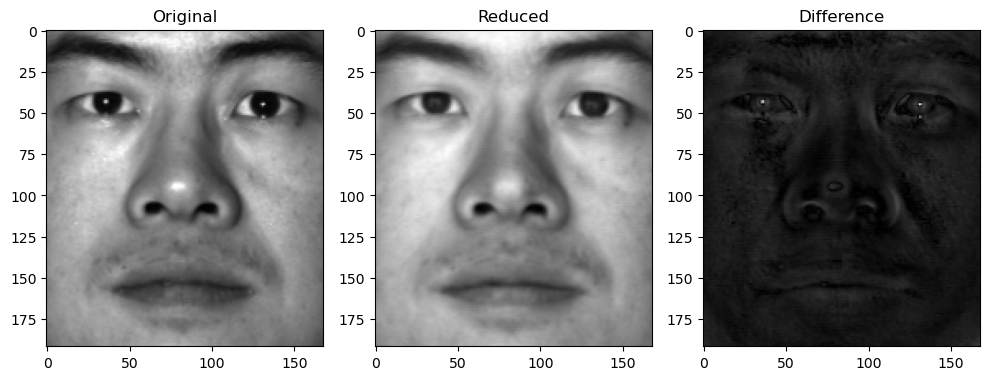

In [9]:
test_choice_ind = 0
test_image_approx = mode_projector(zero_avg_test, u_red)
test_image_approx += avg_test

test_true_mat = test_images[:, test_choice_ind].reshape(crp_row, crp_col)
test_approx_mat = test_image_approx[:, test_choice_ind].reshape(crp_row, crp_col)

image_comparison(test_true_mat, test_approx_mat)

## Projecting Beans

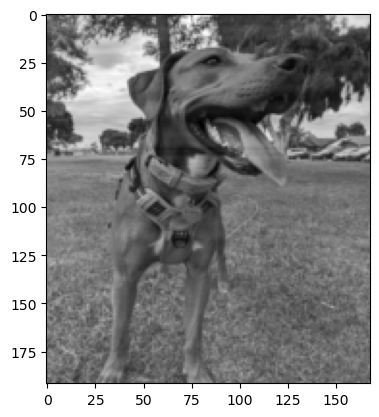

In [10]:
beanie = io.imread('beans.jpg', as_gray=True)
small_beans = resize(beanie, (crp_row, crp_col), anti_aliasing=True)
zero_avg_beans, beans_avg = zero_mean(small_beans)
plt.imshow(zero_avg_beans, cmap=plt.cm.gray)

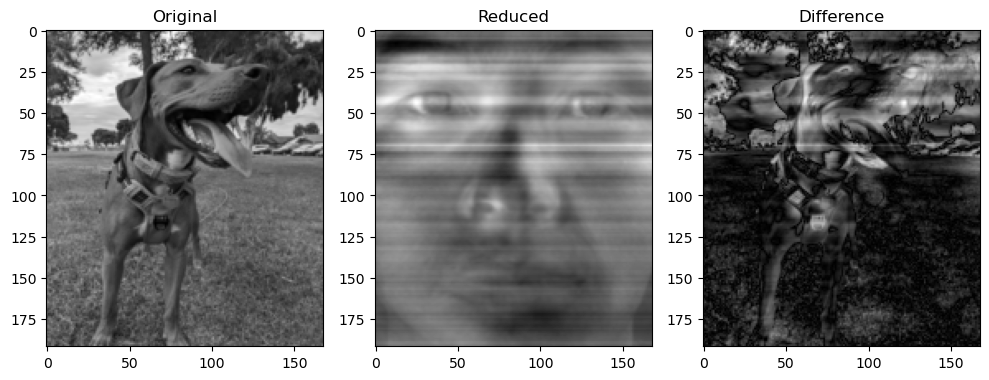

In [11]:
respanned_beans = mode_projector(zero_avg_beans.flatten(), u_red)
rebuilt_beans = respanned_beans.reshape(crp_row, crp_col) + beans_avg
image_comparison(small_beans, rebuilt_beans)

## K-Means Clustering and Type Identification

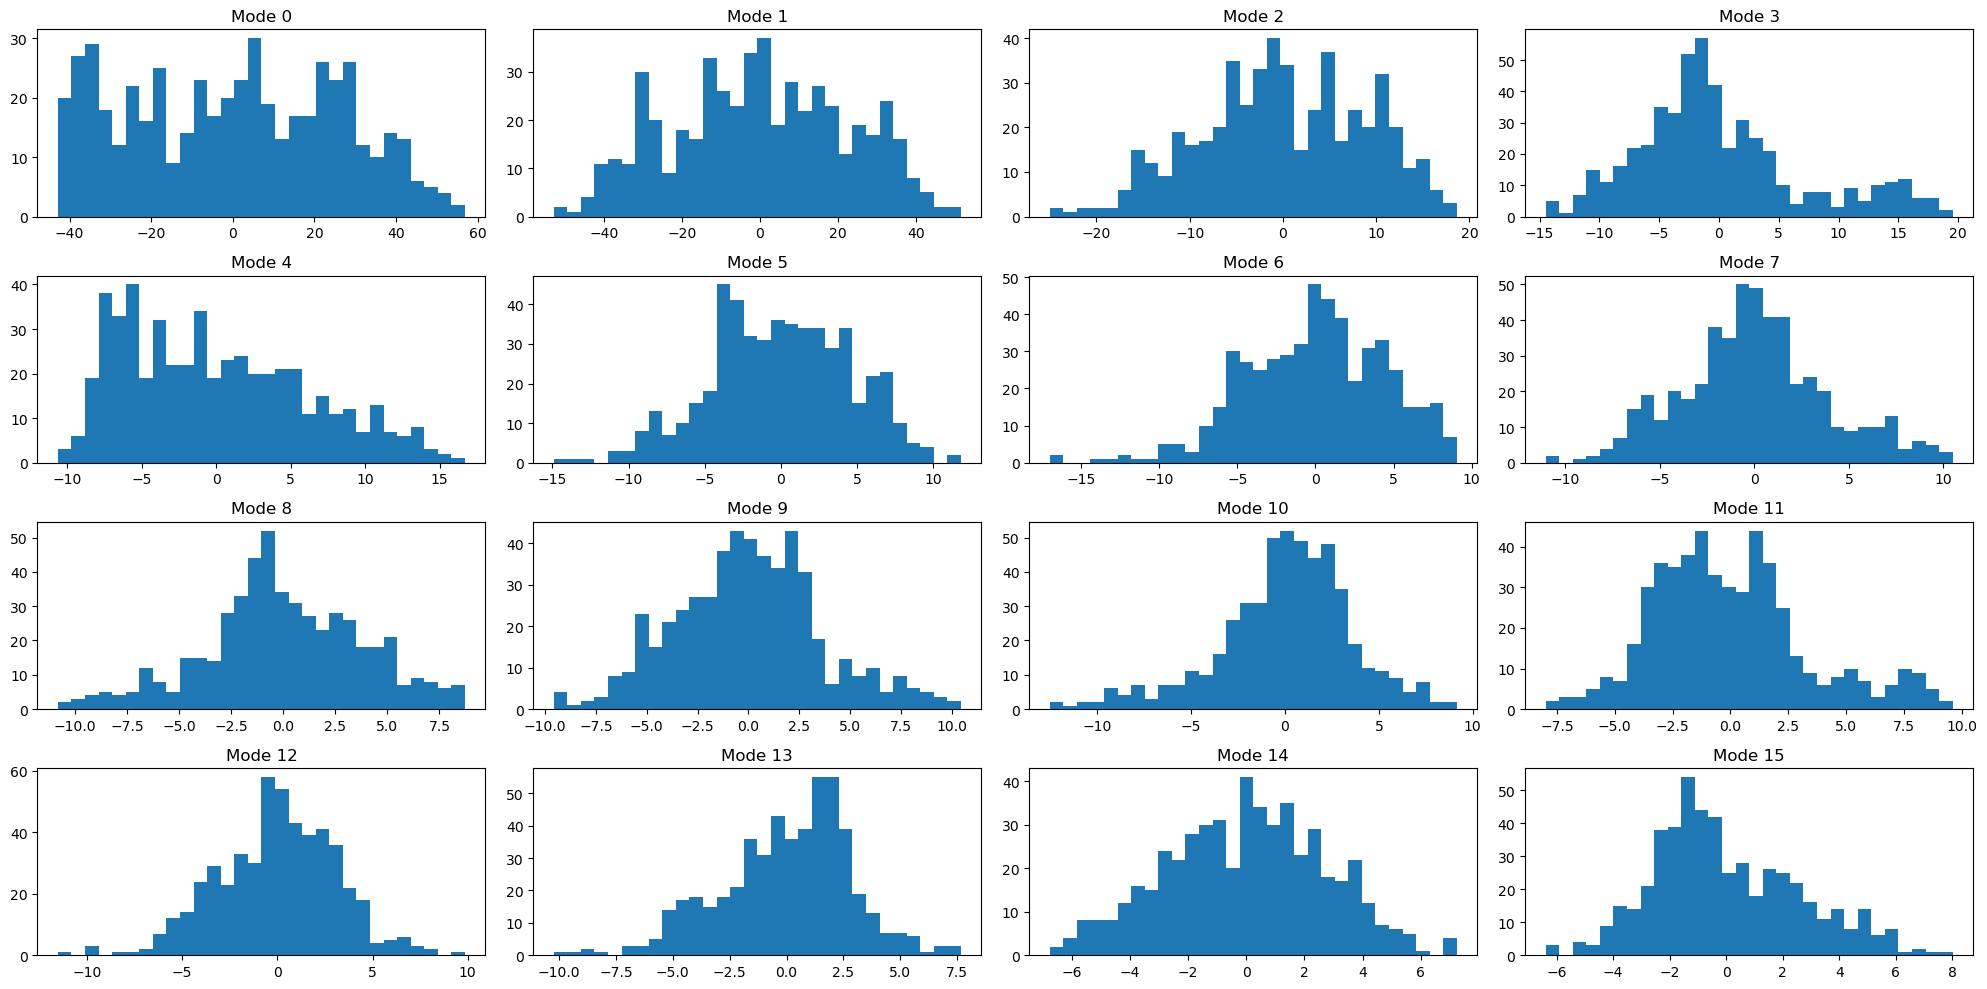

In [12]:
zero_avg_crp, avg_crp = zero_mean(crp_image_mat)
u_crp, s_crp = mode_builder(zero_avg_crp)
u_crp_red = mode_selector(u_crp, s_crp, 1.)

projected_images = u_crp_red.T @ zero_avg_crp
num_modes = u_crp_red.shape[1]

fig, axes = plt.subplots(4, 4, figsize=(20, 10))
ax = axes.ravel()
num_bins = 30
for jj in range(num_modes):
  ax[jj].hist(projected_images[jj, :], bins=num_bins)
  #ax[jj].plot(projected_images[jj, :])
  ax[jj].set_title(f"Mode {jj}")
plt.tight_layout()


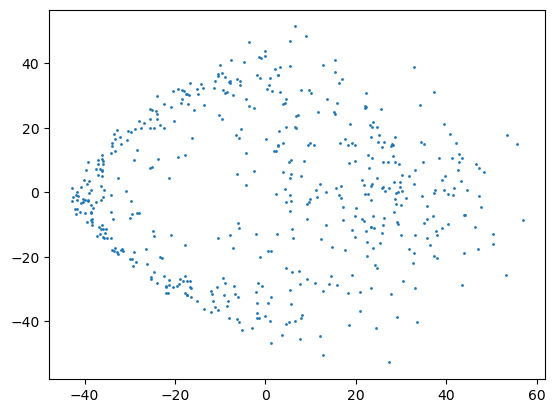

In [13]:
plt.scatter(projected_images[0, :], projected_images[1, :], s=1.)

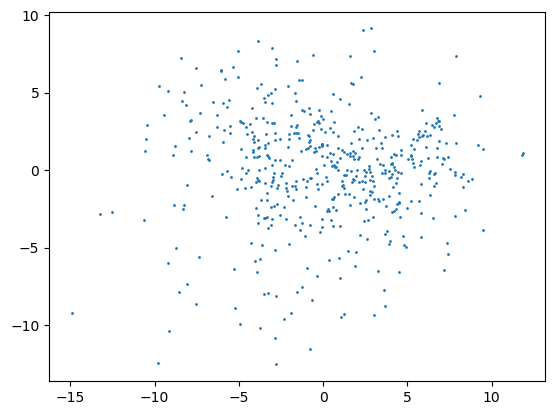

In [14]:
plt.scatter(projected_images[5, :], projected_images[10, :], s=1.)

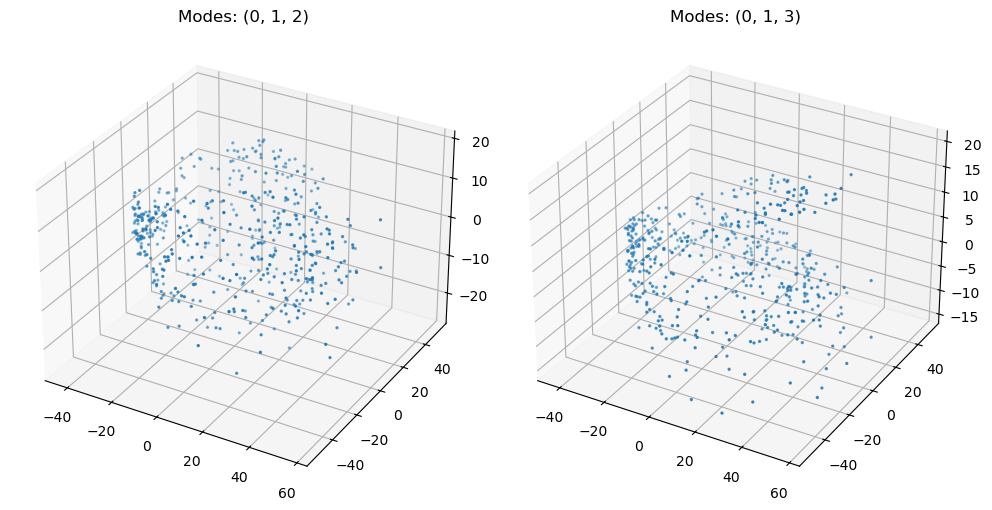

In [15]:
comb_list = [[0, 1, 2], [0, 1, 3]] # add your particular choices here

fig = plt.figure(figsize=(10, 5))
for jj in range(len(comb_list)):
  x = projected_images[comb_list[jj][0], :]
  y = projected_images[comb_list[jj][1], :]
  z = projected_images[comb_list[jj][2], :]
  ax = fig.add_subplot(1, len(comb_list), jj+1, projection='3d') # you might need to adjust this depending on how many images you want to plot at once
  ax.scatter(x, y, z, s=2.)
  ax.set_title(f"Modes: ({comb_list[jj][0]}, {comb_list[jj][1]}, {comb_list[jj][2]})")

plt.tight_layout()

(2, 512)


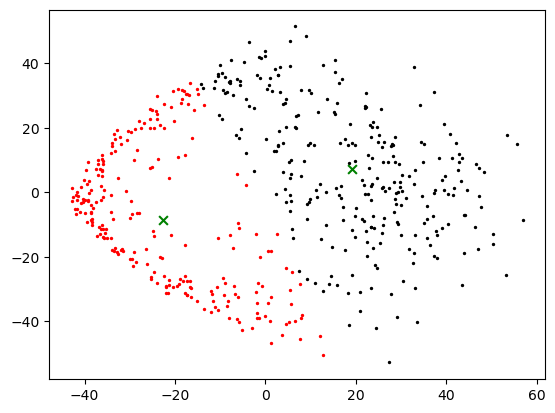

In [16]:
cluster_data = np.array([projected_images[0, :], projected_images[1, :]])
print(cluster_data.shape)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(cluster_data.T)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

group_one = labels == 1
group_two = labels == 0
cluster_one = cluster_data[:,group_one]
cluster_two = cluster_data[:, group_two]

plt.scatter(cluster_one[0, :], cluster_one[1, :], s=2., c='r')
plt.scatter(cluster_two[0, :], cluster_two[1, :], s=2., c='k')
plt.scatter(centers[:, 0], centers[:, 1], s=40., c='g', marker='x')